# Computer Vision. Blood cells.

## Task 2:

Object detection on the dataset https://github.com/Shenggan/BCCD_Dataset.

Let's download the dataset using the git-command:
 - git clone https://github.com/Shenggan/BCCD_Dataset.git

<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;"> Overview of dataset:</h4>
</div>

We have three kind of labels :

 - RBC (Red Blood Cell)
 - WBC (White Blood Cell)
 - Platelets (血小板)

The structure of the BCCD_dataset:
```text
├── BCCD
│   ├── Annotations
│   │       └── BloodImage_00XYZ.xml (364 items)
│   ├── ImageSets       # Contain four Main/*.txt which split the dataset
│   └── JPEGImages
│       └── BloodImage_00XYZ.jpg (364 items)
├── dataset
│   └── mxnet           # Some preprocess scripts for mxnet
├── scripts
│   ├── split.py        # A script to generate four .txt in ImageSets
│   └── visualize.py    # A script to generate labeled img like example.jpg
├── example.jpg         # A example labeled img generated by visualize.py
├── LICENSE
└── README.md

The JPEGImages:
 - Image Type : jpeg(JPEG)
 - Width x Height : 640 x 480

The Annotations : The VOC format .xml for Object Detection, automatically generate by the label tools. Below is an example of .xml file.
The structure of the BCCD_dataset:
```xml
<annotation>
	<folder>JPEGImages</folder>
	<filename>BloodImage_00000.jpg</filename>
	<path>/home/pi/detection_dataset/JPEGImages/BloodImage_00000.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>640</width>
		<height>480</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>WBC</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>260</xmin>
			<ymin>177</ymin>
			<xmax>491</xmax>
			<ymax>376</ymax>
		</bndbox>
	</object>
    ...
	<object>
		...
	</object>
</annotation>

<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;">Dataset</h4>
</div>

In [1]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as T
from PIL import Image
import os
import xml.etree.ElementTree as ET

We created a custom BCCDDataset class in PyTorch to load blood cell images and their annotations from the BCCD dataset.
 - Invalid bounding boxes with zero size or negative dimensions are filtered out to ensure training stability.

In [2]:
class BCCDDataset(Dataset):
    """
    Custom PyTorch Dataset for the BCCD (Blood Cell Count and Detection) dataset.

    This dataset loader reads images and corresponding Pascal VOC XML annotations,
    and prepares the data for object detection models such as Faster R-CNN.

    Attributes:
        image_dir (str): Path to the directory containing image files (.jpg).
        annotation_dir (str): Path to the directory containing XML annotation files.
        transforms (callable, optional): Optional image transformations to apply (e.g., ToTensor()).
        label_map (dict): Mapping from class names (e.g., 'RBC') to integer label IDs.

    Returns:
        image (Tensor): Transformed image tensor (C x H x W).
        target (dict): Dictionary containing:
            - 'boxes': Tensor of shape (N, 4) with bounding boxes in [xmin, ymin, xmax, ymax] format.
            - 'labels': Tensor of shape (N,) with class labels as integers.
    """
    def __init__(self, image_dir, annotation_dir, transforms=None, label_map=None):
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.transforms = transforms
        self.label_map = label_map or {'RBC': 1, 'WBC': 2, 'Platelets': 3}
        self.images = sorted(os.listdir(image_dir))

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        ann_path = os.path.join(self.annotation_dir, self.images[idx].replace('.jpg', '.xml'))

        img = Image.open(img_path).convert('RGB')
        boxes, labels = self.parse_voc_xml(ann_path)

        target = {
            'boxes': torch.tensor(boxes, dtype=torch.float32),
            'labels': torch.tensor(labels, dtype=torch.int64),
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.images)

    def parse_voc_xml(self, xml_path):
        tree = ET.parse(xml_path)
        root = tree.getroot()
        boxes, labels = [], []
    
        for obj in root.findall('object'):
            name = obj.find('name').text
            label = self.label_map[name]
            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
    
            # Filter for invalid bounding boxes
            if xmax > xmin and ymax > ymin:
                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(label)
    
        return boxes, labels

Let's check that all boxes are correct (zero size or negative dimensions ...):

In [3]:
def find_bad_boxes_in_dataset(dataset: BCCDDataset, min_size=5):
    """
    Scans a BCCDDataset for invalid bounding boxes.

    A bounding box is considered bad if:
    - Width or height is less than min_size
    - xmax <= xmin or ymax <= ymin (invalid geometry)
    - The box lies partially or completely outside the image boundaries

    Parameters:
        dataset (BCCDDataset): The dataset to scan (must contain image_dir and annotation_dir).
        min_size (int): Minimum width and height for a valid box (in pixels).

    Returns:
        List[Dict]: A list of dictionaries, each containing information about a bad box:
            - 'idx': Index in dataset
            - 'image': Image file name
            - 'label': Object class label
            - 'box': [xmin, ymin, xmax, ymax]
            - 'box_size': (width, height)
            - 'image_size': (width, height)
    """
    bad_boxes_info = []

    # Iterate through each image/annotation pair
    for idx in range(len(dataset)):
        img_filename = dataset.images[idx]
        xml_path = os.path.join(dataset.annotation_dir, img_filename.replace('.jpg', '.xml'))
        img_path = os.path.join(dataset.image_dir, img_filename)

        try:
            img = Image.open(img_path).convert('RGB')
            width, height = img.size

            # Parse the corresponding XML annotation file
            tree = ET.parse(xml_path)
            root = tree.getroot()

            # Iterate through each object in the annotation
            for obj in root.findall('object'):
                name = obj.find('name').text
                bndbox = obj.find('bndbox')

                # Extract box coordinates
                xmin = int(float(bndbox.find('xmin').text))
                ymin = int(float(bndbox.find('ymin').text))
                xmax = int(float(bndbox.find('xmax').text))
                ymax = int(float(bndbox.find('ymax').text))

                box_width = xmax - xmin
                box_height = ymax - ymin

                # Check for invalid box conditions
                if (
                    # zero or negative dimensions
                    xmax <= xmin or ymax <= ymin  
                    # too small
                    or box_width < min_size or box_height < min_size  
                    # out of image bounds
                    or xmax > width or ymax > height           
                ):
                    bad_boxes_info.append({
                        'idx': idx,
                        'image': img_filename,
                        'label': name,
                        'box': [xmin, ymin, xmax, ymax],
                        'box_size': (box_width, box_height),
                        'image_size': (width, height)
                    })

        except Exception as e:
            print(f'[Error] {img_filename}: {e}')

    return bad_boxes_info

In [4]:
images_dir = 'BCCD_Dataset/BCCD/JPEGImages'
train_path = 'BCCD_Dataset/BCCD/ImageSets/Main/train.txt'
annotations_dir = "BCCD_Dataset/BCCD/Annotations"
label_map = {'RBC': 1, 'WBC': 2, 'Platelets': 3}

In [5]:
dataset = BCCDDataset(image_dir=images_dir, annotation_dir=annotations_dir, transforms=T.ToTensor())

In [6]:
dataset_size = len(dataset)

In [7]:
dataset_size

364

In [8]:
bad_boxes = find_bad_boxes_in_dataset(dataset)
print(f'Invalid bounding boxes: {len(bad_boxes)}')
for b in bad_boxes:
    print(f'{b['idx']}: {b['image']} | {b['label']} | box={b['box']} | size={b['box_size']}')

Invalid bounding boxes: 2
299: BloodImage_00338.jpg | RBC | box=[504, 337, 504, 337] | size=(0, 0)
304: BloodImage_00343.jpg | RBC | box=[181, 329, 181, 329] | size=(0, 0)


So.. we have 2 bad boxes and we will ignore them.

<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;">Split Dataset</h4>
</div>

In [9]:
from torch.utils.data import random_split

We split the dataset into three parts using the random_split function:
 - 70% for training,
 - 15% for validation,
 - 15% for testing.

In [10]:
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size  

In [11]:
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [12]:
len(train_dataset)

254

In [13]:
len(val_dataset)

54

In [14]:
len(test_dataset)

56

<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;">DataLoader and collate_fn</h4>
</div>

In [15]:
from torch.utils.data import DataLoader

We created custom DataLoaders for training, validation, and testing using a collate_fn to handle variable-size batches.
 - Shuffling is enabled for training, and disabled for validation and testing for consistent evaluation.

In [16]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [17]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;">Visualization</h4>
</div>

In [18]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

Let's visualize a sample batch of training images to verify the correctness of the dataset annotations.
Each image shows bounding boxes over blood cells, color-coded by class:
 - Red for RBC,
 - Blue for WBC,
 - Green for Platelets.

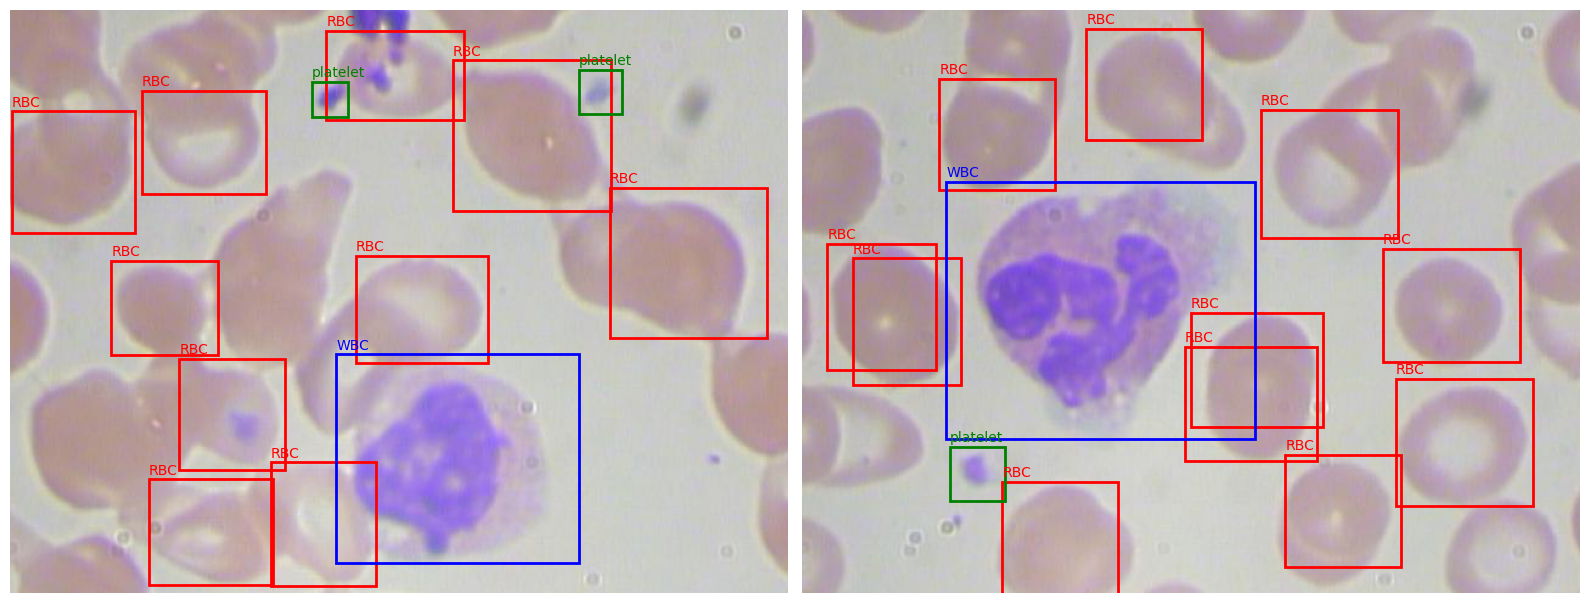

In [19]:
# Get one batch from the training DataLoader
images, targets = next(iter(train_loader))
# Mapping of classes and colors for visualization
label_map = {1: 'RBC', 2: 'WBC', 3: 'platelet'}
colors = {1: 'red', 2: 'blue', 3: 'green'}
# Display the first 2 images
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
for i in range(2):
    # Convert image tensor
    img = images[i].permute(1, 2, 0).numpy()
    boxes = targets[i]['boxes']
    labels = targets[i]['labels']
    
    ax = axs[i]
    ax.imshow(img)
    ax.axis('off')
    # Draw bounding box with labels
    for box, label in zip(boxes, labels):
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=2, edgecolor=colors[int(label)], facecolor='none')
        ax.add_patch(rect)
        ax.text(xmin, ymin - 4, label_map[int(label)],
                color=colors[int(label)], fontsize=10)
plt.tight_layout()
plt.show()

<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;">FasterRCNN</h4>
</div>

In [20]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

We used a pre-trained Faster R-CNN with ResNet-50 FPN backbone from torchvision.
The model head was replaced with a custom classifier to support 4 classes (background + RBC + WBC + Platelets).
The COCO pre-trained weights (DEFAULT) were used to initialize the backbone.

In [21]:
def get_model(num_classes):
    """
    Returns a Faster R-CNN model with a ResNet-50 FPN backbone, pre-trained on COCO,
    and customized for a specified number of output classes.

    Args:
        num_classes (int): The number of object classes including background (background = 0).

    Returns:
        model (torch.nn.Module): A modified Faster R-CNN model ready for training or inference.
    """
    # Loading pre-trained weights
    weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
    # Load the Faster R-CNN model with a ResNet-50 backbone and Feature Pyramid Network 
    model = fasterrcnn_resnet50_fpn(weights=weights)
    
    # Change head
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Create and assign a new predictor for 4 classes (including background = 0)
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=4)

    return model

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
# Creating model
model = get_model(num_classes=4)
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;">Optimizer</h4>
</div>

We used the Stochastic Gradient Descent (SGD) optimizer with the following parameters:
 - Learning rate: 0.005
 - Momentum: 0.9 (to accelerate convergence)
 - Weight decay: 0.0005 (for L2 regularization)
 - Model parameters with requires_grad=True were passed to the optimizer, ensuring that frozen layers (if any) are excluded from training.

In [24]:
# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;">Training</h4>
</div>

In [25]:
import torch
from tqdm import tqdm
from torchvision.ops import box_iou

Implementation a custom train_one_epoch() function to train the Faster R-CNN model.

We will compute metrics:
 - loss_classifier. Cross-entropy loss for classifying objects (RBC, WBC, Platelet, BG).
 - loss_box_reg. Smooth L1 loss for refining bounding box coordinates (localization loss).
 - loss_objectness. Binary classification loss for foreground/background in RPN.
 - loss_rpn_box_reg. Smooth L1 loss for regressing anchor box positions in RPN.
 - avg_loss. The total loss is a sum of classification and localization losses from both the Region Proposal Network and the final detection head.
Monitoring these components helps track which part of the model is learning or struggling.

In [26]:
def train_one_epoch(model, data_loader, optimizer, device):
    model.train()
    epoch_loss = 0.0
    loss_log = {
        'loss_classifier': 0.0,
        'loss_box_reg': 0.0,
        'loss_objectness': 0.0,
        'loss_rpn_box_reg': 0.0
    }

    pbar = tqdm(data_loader, desc="Training", leave=False)

    for images, targets in pbar:
        # Move data to device
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)
        total_loss = sum(loss_dict.values())

        # Backpropagation
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # Accumulate total and individual losses
        epoch_loss += total_loss.item()
        for k in loss_log:
            loss_log[k] += loss_dict[k].item()

        # Show current loss values in progress bar
        pbar.set_postfix(
            total=f"{total_loss.item():.3f}",
            cls=f"{loss_dict['loss_classifier'].item():.3f}",
            reg=f"{loss_dict['loss_box_reg'].item():.3f}"
        )

    # Average all losses
    avg_loss = epoch_loss / len(data_loader)
    avg_loss_dict = {k: v / len(data_loader) for k, v in loss_log.items()}
    avg_loss_dict['avg_loss'] = avg_loss

    return avg_loss_dict

In [27]:
# Disable gradient calculation during evaluation for better performance
@torch.no_grad()  
def evaluate_model(model, data_loader, device, score_threshold=0.5):
    """
    Runs inference on a dataset and collects predictions and ground truth.

    Args:
        model (torch.nn.Module): Trained object detection model.
        data_loader (DataLoader): DataLoader for validation or test dataset.
        device (torch.device): The device to run inference on.
        score_threshold (float): Confidence threshold for filtering predictions.

    Returns:
        List[Dict]: A list of dictionaries, each containing:
            - 'boxes': predicted bounding boxes (filtered by score)
            - 'labels': predicted class labels
            - 'scores': confidence scores
            - 'image': the original image tensor
            - 'target': ground truth annotations (boxes and labels)
    """
    # Evaluation mode
    model.eval()  
    all_outputs = []  
    # Progress bar for evaluation
    pbar = tqdm(data_loader, desc="Evaluating", leave=False)  
    for images, targets in pbar:
        images = [img.to(device) for img in images]
        # Get model predictions
        outputs = model(images)  

        for i, output in enumerate(outputs):
            boxes = output['boxes'].detach().cpu()
            labels = output['labels'].detach().cpu()
            scores = output['scores'].detach().cpu()

            # Filter out low-confidence predictions
            keep = scores >= score_threshold
            result = {
                # Predictions
                'boxes': boxes[keep],                     
                'labels': labels[keep],                   
                'scores': scores[keep],                   
                'image': images[i].cpu(),  
                # Ground truth
                'target': {k: v.cpu() for k, v in targets[i].items()}  
            }
            all_outputs.append(result) 

    return all_outputs  

In [68]:
def compute_metrics_per_class(results, iou_threshold=0.5, num_classes=3):
    """
    Computes detection metrics per class (Precision, Recall, mean IoU) based on model predictions.

    Args:
        results (List[Dict]): Output from evaluate_model(), 
            each entry contains predictions and ground truth.
        iou_threshold (float): IoU threshold to consider a prediction as a True Positive.
        num_classes (int): Number of object classes (excluding background).

    Returns:
        dict: A dictionary with per-class metrics:
            - 'precision': per-class precision
            - 'recall': per-class recall
            - 'mean IoU': average IoU for correctly matched boxes
            - 'TP', 'FP', 'FN': true positives, false positives, false negatives per class
    """
    stats = {
        "precision": {},
        "recall": {},
        "mean IoU": {},
        "TP": {},
        "FP": {},
        "FN": {}
    }

    for cls_id in range(1, num_classes + 1):
        tp = 0
        fp = 0
        fn = 0
        total_iou = 0
        iou_count = 0

        for result in results:
            # Фильтруем по классу
            pred_mask = result['labels'] == cls_id
            gt_mask = result['target']['labels'] == cls_id

            pred_boxes = result['boxes'][pred_mask]
            gt_boxes = result['target']['boxes'][gt_mask]

            if len(pred_boxes) == 0 and len(gt_boxes) == 0:
                continue
            elif len(pred_boxes) == 0:
                fn += len(gt_boxes)
                continue
            elif len(gt_boxes) == 0:
                fp += len(pred_boxes)
                continue

            ious = box_iou(pred_boxes, gt_boxes)
            matched_gt = set()

            for pred_idx in range(ious.size(0)):
                max_iou, gt_idx = torch.max(ious[pred_idx], dim=0)
                if max_iou >= iou_threshold and int(gt_idx) not in matched_gt:
                    tp += 1
                    total_iou += max_iou.item()
                    iou_count += 1
                    matched_gt.add(int(gt_idx))
                else:
                    fp += 1

            fn += len(gt_boxes) - len(matched_gt)

        precision = tp / (tp + fp + 1e-6)
        recall = tp / (tp + fn + 1e-6)
        mean_iou = total_iou / (iou_count + 1e-6)

        stats["precision"][cls_id] = precision
        stats["recall"][cls_id] = recall
        stats["mean IoU"][cls_id] = mean_iou
        stats["TP"][cls_id] = tp
        stats["FP"][cls_id] = fp
        stats["FN"][cls_id] = fn

    return stats

We trained the model for 15 epochs, recording both training and validation loss components.

In [29]:
num_epochs = 15
history_train = { 'avg_loss': [], 'loss_classifier': [], 'loss_box_reg': [], 'loss_objectness': [], 'loss_rpn_box_reg': [] }
history_val = { 'avg_loss': [] }

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    
    # Training
    avg_train_loss_dict = train_one_epoch(model, train_loader, optimizer, device)
    for k in history_train:
        history_train[k].append(avg_train_loss_dict[k])
    
    # Validation
    val_results = evaluate_model(model, val_loader, device)
    val_metrics = compute_metrics_per_class(val_results)
    mean_val_iou = sum(val_metrics['mean IoU'].values()) / len(val_metrics['mean IoU'])
    val_loss_proxy = 1 - mean_val_iou
    history_val['avg_loss'].append(val_loss_proxy)

    print("Train Losses:")
    for k, v in avg_train_loss_dict.items():
        print(f"  {k}: {v:.4f}")
    print(f"Validation mean IoU: {mean_val_iou:.4f} | Proxy Val Loss: {val_loss_proxy:.4f}")


Epoch 1/15


Train Losses:
  loss_classifier: 0.2863
  loss_box_reg: 0.4108
  loss_objectness: 0.0234
  loss_rpn_box_reg: 0.0258
  avg_loss: 0.7463
Validation mean IoU: 0.8229 | Proxy Val Loss: 0.1771

Epoch 2/15


Train Losses:
  loss_classifier: 0.1943
  loss_box_reg: 0.2948
  loss_objectness: 0.0130
  loss_rpn_box_reg: 0.0191
  avg_loss: 0.5212
Validation mean IoU: 0.8309 | Proxy Val Loss: 0.1691

Epoch 3/15


Train Losses:
  loss_classifier: 0.1819
  loss_box_reg: 0.2645
  loss_objectness: 0.0098
  loss_rpn_box_reg: 0.0173
  avg_loss: 0.4734
Validation mean IoU: 0.8389 | Proxy Val Loss: 0.1611

Epoch 4/15


Train Losses:
  loss_classifier: 0.1720
  loss_box_reg: 0.2438
  loss_objectness: 0.0092
  loss_rpn_box_reg: 0.0155
  avg_loss: 0.4405
Validation mean IoU: 0.8338 | Proxy Val Loss: 0.1662

Epoch 5/15


Train Losses:
  loss_classifier: 0.1604
  loss_box_reg: 0.2297
  loss_objectness: 0.0084
  loss_rpn_box_reg: 0.0145
  avg_loss: 0.4130
Validation mean IoU: 0.8333 | Proxy Val Loss: 0.1667

Epoch 6/15


Train Losses:
  loss_classifier: 0.1482
  loss_box_reg: 0.2159
  loss_objectness: 0.0074
  loss_rpn_box_reg: 0.0141
  avg_loss: 0.3855
Validation mean IoU: 0.8295 | Proxy Val Loss: 0.1705

Epoch 7/15


Train Losses:
  loss_classifier: 0.1451
  loss_box_reg: 0.2085
  loss_objectness: 0.0062
  loss_rpn_box_reg: 0.0132
  avg_loss: 0.3730
Validation mean IoU: 0.8355 | Proxy Val Loss: 0.1645

Epoch 8/15


Train Losses:
  loss_classifier: 0.1282
  loss_box_reg: 0.1962
  loss_objectness: 0.0057
  loss_rpn_box_reg: 0.0127
  avg_loss: 0.3427
Validation mean IoU: 0.8264 | Proxy Val Loss: 0.1736

Epoch 9/15


Train Losses:
  loss_classifier: 0.1186
  loss_box_reg: 0.1846
  loss_objectness: 0.0056
  loss_rpn_box_reg: 0.0115
  avg_loss: 0.3202
Validation mean IoU: 0.8395 | Proxy Val Loss: 0.1605

Epoch 10/15


Train Losses:
  loss_classifier: 0.1146
  loss_box_reg: 0.1797
  loss_objectness: 0.0045
  loss_rpn_box_reg: 0.0113
  avg_loss: 0.3102
Validation mean IoU: 0.8354 | Proxy Val Loss: 0.1646

Epoch 11/15


Train Losses:
  loss_classifier: 0.0966
  loss_box_reg: 0.1607
  loss_objectness: 0.0040
  loss_rpn_box_reg: 0.0098
  avg_loss: 0.2711
Validation mean IoU: 0.8312 | Proxy Val Loss: 0.1688

Epoch 12/15


Train Losses:
  loss_classifier: 0.0803
  loss_box_reg: 0.1527
  loss_objectness: 0.0032
  loss_rpn_box_reg: 0.0092
  avg_loss: 0.2454
Validation mean IoU: 0.8334 | Proxy Val Loss: 0.1666

Epoch 13/15


Train Losses:
  loss_classifier: 0.0756
  loss_box_reg: 0.1447
  loss_objectness: 0.0024
  loss_rpn_box_reg: 0.0089
  avg_loss: 0.2316
Validation mean IoU: 0.8363 | Proxy Val Loss: 0.1637

Epoch 14/15


Train Losses:
  loss_classifier: 0.0665
  loss_box_reg: 0.1358
  loss_objectness: 0.0019
  loss_rpn_box_reg: 0.0079
  avg_loss: 0.2121
Validation mean IoU: 0.8325 | Proxy Val Loss: 0.1675

Epoch 15/15


Train Losses:
  loss_classifier: 0.0625
  loss_box_reg: 0.1248
  loss_objectness: 0.0018
  loss_rpn_box_reg: 0.0080
  avg_loss: 0.1970
Validation mean IoU: 0.8439 | Proxy Val Loss: 0.1561


In [31]:
# Save the model
torch.save(model.state_dict(), "v2.pth")

<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;">Train vs Validation Loss</h4>
</div>

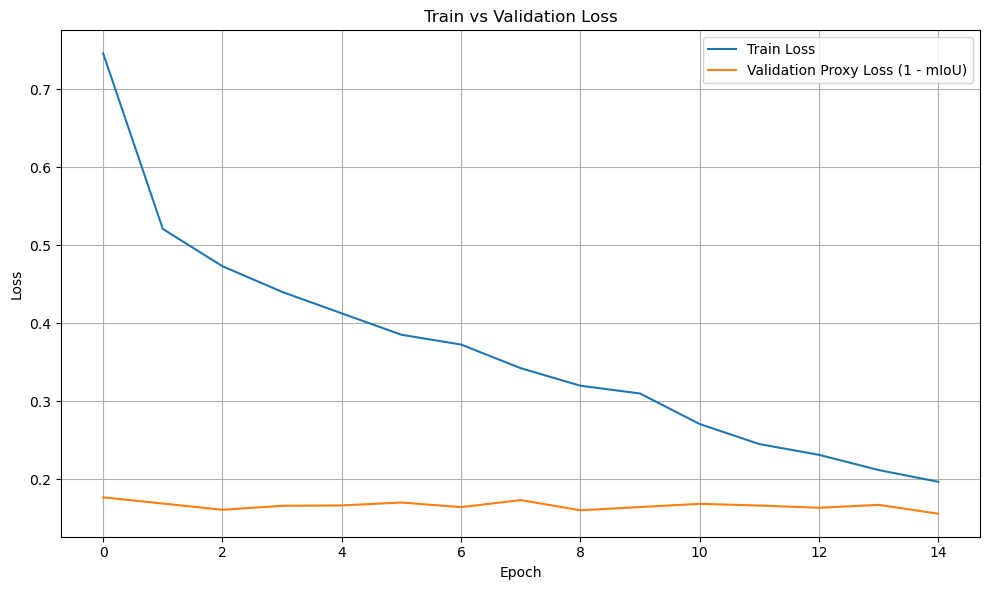

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(history_train['avg_loss'], label="Train Loss")
plt.plot(history_val['avg_loss'], label="Validation Loss (1 - mIoU)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Training and validation curves indicate stable learning without overfitting.
The training loss steadily decreases, while the validation loss remains stable across all epochs.

<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;">Predictions</h4>
</div>

We visualized model predictions and ground truth bounding boxes on blood cell images.
Ground truth boxes are shown in dashed green, while predictions are displayed in color-coded boxes based on class.
This helps visually evaluate the model’s detection accuracy and alignment with annotated data.

In [45]:
def plot_predictions_vs_ground_truth(result, label_map=None):
    """
    Visualizes predicted bounding boxes and ground truth boxes on a single image.

    Args:
        result (dict): A dictionary from evaluate_model(), containing:
            - 'image': the image tensor
            - 'boxes': predicted bounding boxes
            - 'labels': predicted class labels
            - 'scores': confidence scores
            - 'target': dictionary with ground truth 'boxes' and 'labels'
        label_map (dict, optional): A mapping from class IDs to class names.
                                    Defaults to {1: 'RBC', 2: 'WBC', 3: 'Platelet'}.

    Displays:
        An image with:
            - Dashed green boxes for ground truth
            - Colored boxes for predictions (red = RBC, blue = WBC, orange = Platelet)
            - Class labels and confidence scores
    """
    label_map = label_map or {1: 'RBC', 2: 'WBC', 3: 'Platelet'}
    colors_gt = {1: 'green', 2: 'green', 3: 'green'}     # ground truth: green dashed boxes
    colors_pred = {1: 'red', 2: 'blue', 3: 'orange'}     # predictions: color-coded boxes

    image = result['image'].permute(1, 2, 0).numpy()
    pred_boxes = result['boxes']
    pred_labels = result['labels']
    pred_scores = result['scores']
    gt_boxes = result['target']['boxes']
    gt_labels = result['target']['labels']

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(image)
    ax.axis('off')

    # Ground Truth (зелёные пунктирные боксы)
    for box, label in zip(gt_boxes, gt_labels):
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=2, edgecolor=colors_gt[int(label)],
                                 facecolor='none', linestyle='--')
        ax.add_patch(rect)
        ax.text(xmin, ymin - 4, f"GT: {label_map[int(label)]}",
                color='green', fontsize=10)

    # Predictions
    for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=2, edgecolor=colors_pred[int(label)],
                                 facecolor='none')
        ax.add_patch(rect)
        ax.text(xmin, ymax + 10, f"{label_map[int(label)]} {score:.2f}",
                color=colors_pred[int(label)], fontsize=10)

    plt.title("Prediction (color) vs Ground Truth (green dashed)")
    plt.tight_layout()
    plt.show()

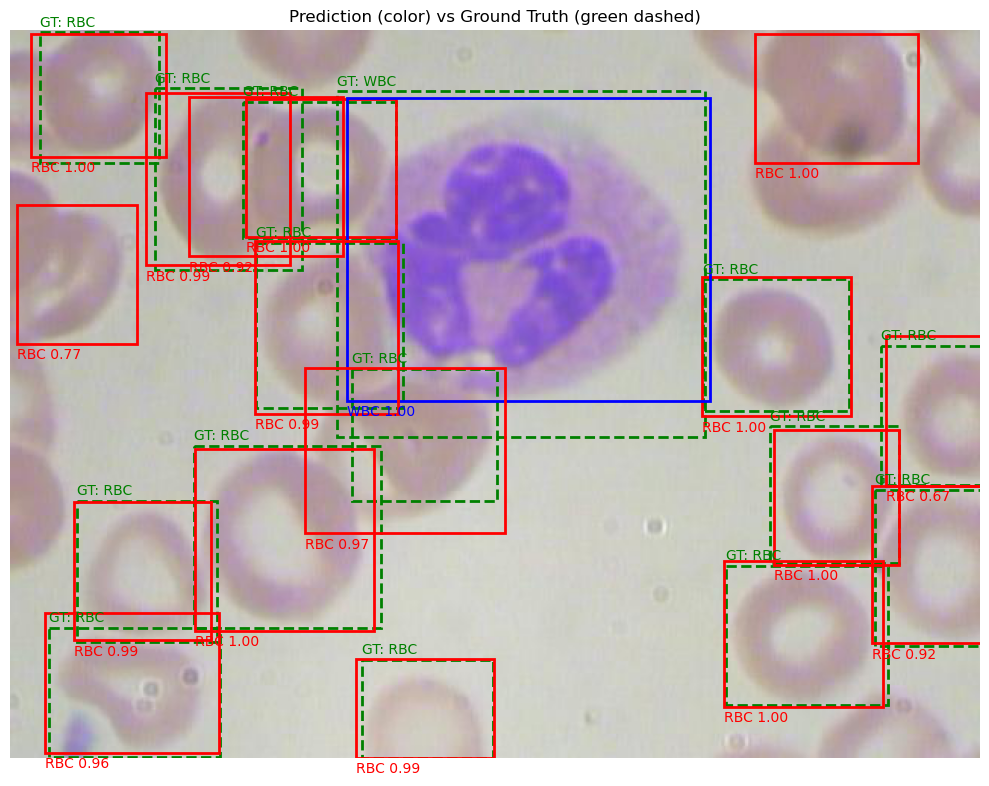

In [57]:
plot_predictions_vs_ground_truth(results[5])  

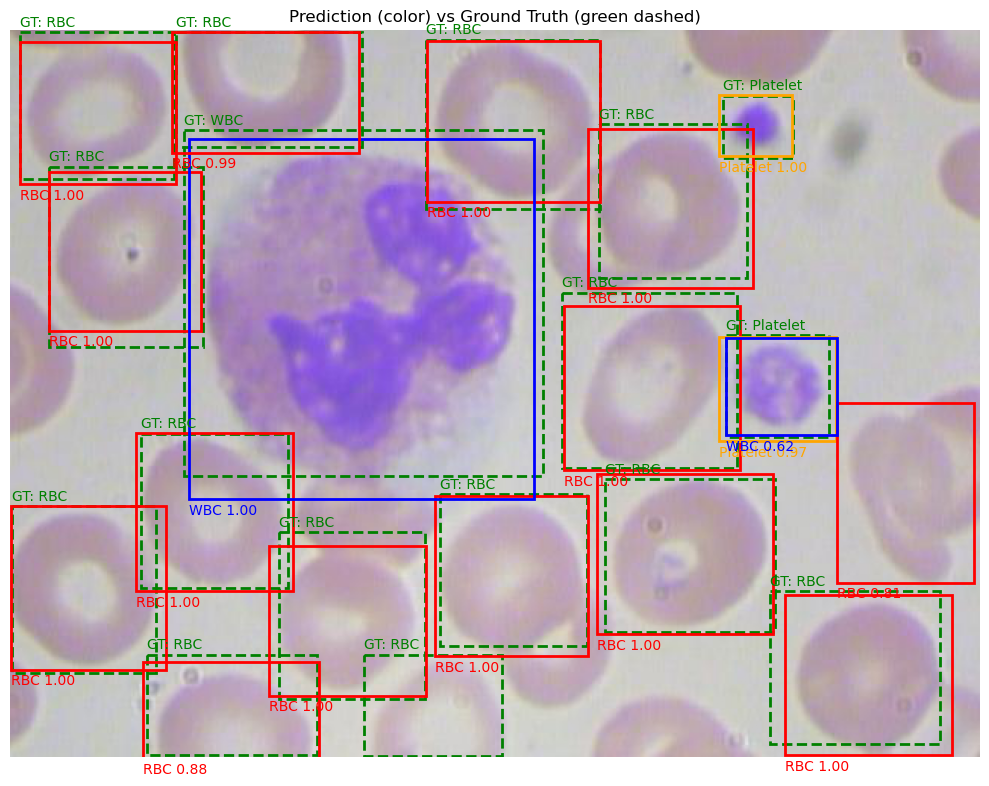

In [65]:
plot_predictions_vs_ground_truth(results[7])  

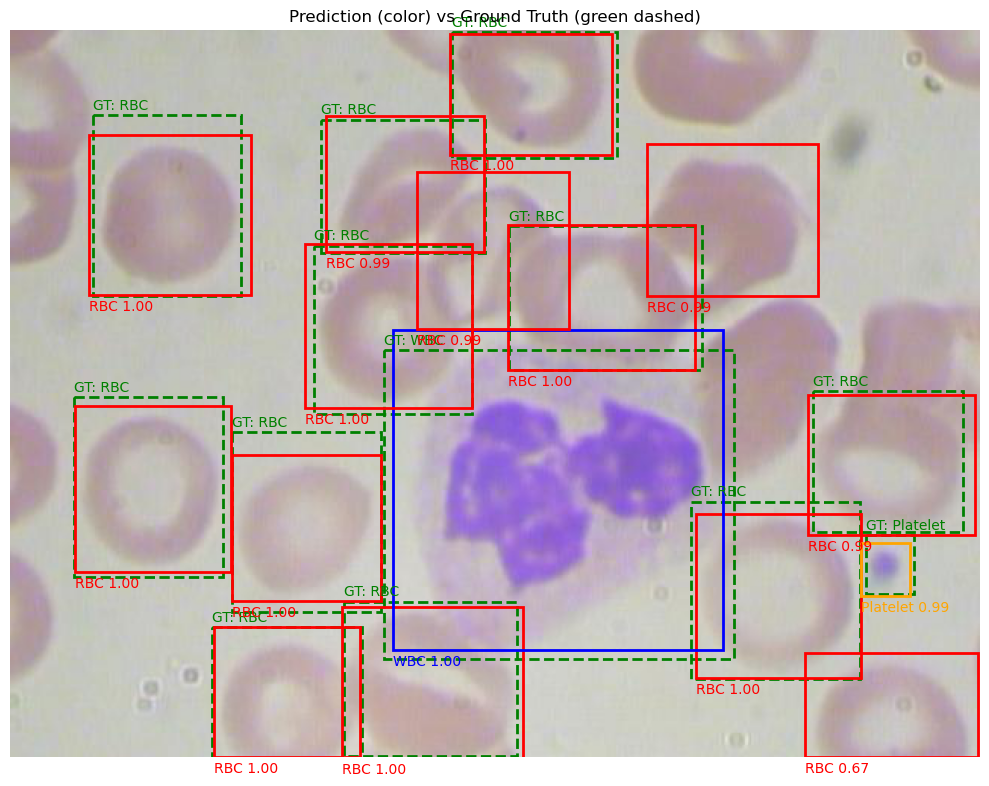

In [55]:
plot_predictions_vs_ground_truth(results[53])  

<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;">Inference on a test</h4>
</div>

This function runs inference on a validation dataset using a trained Faster R-CNN model.

In [72]:
import pandas as pd

In [73]:
results = evaluate_model(model, test_loader, device)

In [79]:
def metrics_to_dataframe(metrics, label_map={1: 'RBC', 2: 'WBC', 3: 'Platelet'}):
    """
    Converts a dictionary of per-class metrics into a formatted pandas DataFrame.

    Args:
        metrics (dict): A dictionary containing per-class metrics
        label_map (dict, optional): A mapping from class IDs to class names.
                                    {1: 'RBC', 2: 'WBC', 3: 'Platelet'}.

    Returns:
        pd.DataFrame: A DataFrame with one row per class and columns:
                      "Class", "Precision", "Recall", "mean IoU", "TP", "FP", "FN"
    """
    rows = []
    for cls_id, name in label_map.items():
        row = {
            "Class": name,
            "Precision": metrics["precision"][cls_id],
            "Recall": metrics["recall"][cls_id],
            "mean IoU": metrics["mean IoU"][cls_id],
            "TP": metrics["TP"][cls_id],
            "FP": metrics["FP"][cls_id],
            "FN": metrics["FN"][cls_id]
        }
        rows.append(row)
    
    df = pd.DataFrame(rows)
    return df

In [80]:
def compute_metrics(results, iou_threshold=0.5):
    """
    Computes global object detection metrics across all classes, without class-wise separation.

    Args:
        results (List[Dict]): Output from evaluate_model(), containing predicted and ground truth boxes per image.
        iou_threshold (float): Minimum IoU to consider a prediction as a true positive (default is 0.5).

    Returns:
        dict: A dictionary with overall metrics:
            - 'precision': Ratio of TP / (TP + FP)
            - 'recall': Ratio of TP / (TP + FN)
            - 'mean IoU': Average IoU over matched boxes
            - 'TP': Total true positives
            - 'FP': Total false positives
            - 'FN': Total false negatives
    """
    tp = 0  # true positives
    fp = 0  # false positives
    fn = 0  # false negatives
    total_iou = 0
    iou_count = 0

    for result in results:
        pred_boxes = result['boxes']
        pred_labels = result['labels']
        gt_boxes = result['target']['boxes']
        gt_labels = result['target']['labels']

        if len(pred_boxes) == 0 and len(gt_boxes) == 0:
            continue
        elif len(pred_boxes) == 0:
            fn += len(gt_boxes)
            continue
        elif len(gt_boxes) == 0:
            fp += len(pred_boxes)
            continue

        ious = box_iou(pred_boxes, gt_boxes)  # [pred, gt]

        matched_gt = set()
        for pred_idx in range(ious.size(0)):
            max_iou, gt_idx = torch.max(ious[pred_idx], dim=0)
            if max_iou >= iou_threshold and int(gt_idx) not in matched_gt:
                tp += 1
                total_iou += max_iou.item()
                iou_count += 1
                matched_gt.add(int(gt_idx))
            else:
                fp += 1

        fn += len(gt_boxes) - len(matched_gt)

    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    mean_iou = total_iou / (iou_count + 1e-6)

    return {
        "precision": precision,
        "recall": recall,
        "mean IoU": mean_iou,
        "TP": tp,
        "FP": fp,
        "FN": fn
    }

In [89]:
metrics = compute_metrics(results)
for key in metrics:
    print(f'{key}: {metrics[key]}')

precision: 0.762295081074596
recall: 0.8797297285409058
mean IoU: 0.8431907076306064
TP: 651
FP: 203
FN: 89


<b>Summary</b>:
 - Precision: 76.2% – most predicted boxes are correct
 - Recall: 87.9% – the model detects nearly all ground truth objects. High recall indicates excellent object coverage.
 - mean IoU: 84.3% – predicted boxes are well-aligned with ground truth. High mean IoU confirms that bounding boxes are accurately localized.

In [82]:
metrics_per_class = compute_metrics_per_class(results)

In [83]:
df_metrics_per_class = metrics_to_dataframe(metrics_per_class)
print(df_metrics_per_class)

      Class  Precision    Recall  mean IoU   TP   FP  FN
0       RBC   0.735537  0.862682  0.847093  534  192  85
1       WBC   0.933333  0.982456  0.886314   56    4   1
2  Platelet   0.867647  0.921875  0.770092   59    9   5


<b>Summary:</b>
 - RBC: Good recall (86%) but moderate precision (73%) due to false positives
 - WBC: Excellent precision (93%) and recall (98%) — consistently detected
 - Platelets: Strong performance overall with 87% precision and 92% recall

Overall, the system shows high generalization and reliable localization across all blood cell types.